## 4. Optional extra credit 2 (up to 3 points) ##
Authors: Bill Zheng, Mike DeMayo, Jed Seiner

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

In [1]:
# Packages for geocoding and plotting
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import re

# Load the jobs data
jobs = pd.read_csv("../pset2/pset2_inputdata/jobs.csv")

# Drop rows with missing address info
jobs = jobs.dropna(subset=["EMPLOYER_ADDRESS_1", "EMPLOYER_CITY", "EMPLOYER_STATE", "EMPLOYER_POSTAL_CODE"])

# Standardize street suffixes for cleaning
suffix_map = {
    r'\bRd\b': 'Road',
    r'\bSt\b': 'Street',
    r'\bAve\b': 'Avenue',
    r'\bHwy\b': 'Highway',
    r'\bDr\b': 'Drive',
    r'\bLn\b': 'Lane',
    r'\bBlvd\b': 'Boulevard',
    r'\bCir\b': 'Circle',
    r'\bCt\b': 'Court'
}
# Filter for georgia jobs
jobs_georgia = jobs[jobs["EMPLOYER_STATE"] == "GA"].copy()

def clean_address(addr):
    if pd.isnull(addr):
        return ""
    addr = addr.replace(".", "")  # Remove periods
    addr = addr.title()
    addr = addr.strip()           # Title-case
    for abbr, full in suffix_map.items():
        addr = re.sub(abbr, full, addr)
    return addr

# Clean address fields
jobs_georgia["EMPLOYER_ADDRESS_1_CLEAN"] = jobs["EMPLOYER_ADDRESS_1"].apply(clean_address)
jobs_georgia["EMPLOYER_CITY_CLEAN"] = jobs["EMPLOYER_CITY"].apply(lambda x: str(x).title())

# Use full state name for accuracy
jobs_georgia["full_address"] = (
    jobs_georgia["EMPLOYER_ADDRESS_1_CLEAN"] + ", " +
    jobs_georgia["EMPLOYER_CITY_CLEAN"] + ", Georgia " +
    jobs_georgia["EMPLOYER_POSTAL_CODE"].astype(str)
)

# Set up geocoder with rate limiter
geolocator = Nominatim(user_agent="geo_jobs_mapper")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, error_wait_seconds=10)

# Function to geocode and extract lat/lon
def safe_geocode(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])
    return pd.Series([None, None])

# Apply geocoding
print("Starting geocoding...")
jobs_georgia[["latitude", "longitude"]] = jobs_georgia["full_address"].apply(safe_geocode)
print("Finished geocoding.")

# Save result
jobs_georgia.to_csv("geocoded_jobs.csv", index=False)
print("Saved geocoded data to geocoded_jobs.csv")


Starting geocoding...
Finished geocoding.
Saved geocoded data to geocoded_jobs.csv


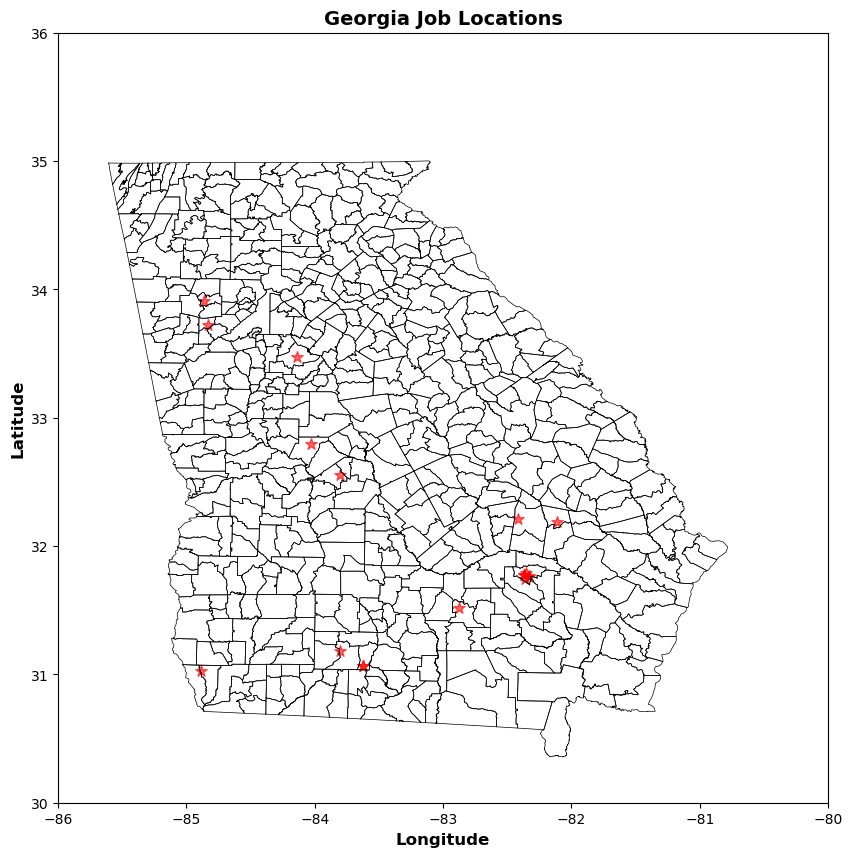

In [4]:
# Load necessary packages
from shapely.geometry import shape, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import fiona

# Read geometries from shapefile again
# Georgia referenced from https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-georgia-current-county-subdivision-state-based
with fiona.open("/Users/mikedemayo/Downloads/tl_2019_13_cousub/tl_2019_13_cousub.shp") as src: 
    geometries = [shape(feat['geometry']) for feat in src]

# Reuse previously loaded job data
job_data = pd.read_csv("../pset2/geocoded_jobs.csv")

# Plotting map of Georgia w/ county lines
result = plt.subplots(figsize=(10, 10))
fig = result[0]
ax = result[1]

# Draw each county shape
for geom in geometries:
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, color="black", linewidth=0.5)
    elif isinstance(geom, MultiPolygon):
        for part in geom.geoms:
            x, y = part.exterior.xy
            ax.plot(x, y, color="black", linewidth=0.5)

# Plot job points
ax.scatter(job_data["longitude"], job_data["latitude"], color="red", s=75, alpha=0.6, marker='*')

# Style map
ax.set_title("Georgia Job Locations", fontsize=14, fontweight = "bold")
ax.set_xlim([-86, -80])
ax.set_ylim([30, 36])
ax.set_aspect("equal")
ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")


plt.show()
